### This code post processes the experiment data of SD7003
- just ensemble average, no filter
- uncertainty:
    - δCp = sqrt((∂Cp/∂p * δlift)^2 + (∂Cp/∂rho * δrho)^2 + (∂Cp/∂u * δu)^2)

In [1]:
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv

cm2in = 1/2.54           # conversion of in to cm
plt.rcParams.update({"font.size": 8})
plt.rcParams['lines.markersize'] ** 5 # set default marker size

Chord     = 0.2              # chord length, m
dChord    = 0.001
len_span  = 0.9
dlen_span = 0.01
Span   = Chord*len_span        # airfoil surface area
dSpan  = dChord*dlen_span
rho  = 998               # kg/m^3
drho = 10
u    = 0.3               # m/s
du   = 0.01

dynP = (0.5*rho*u**2)  # dynamic pressure

Color = ['#9d1939', '#0b1f38', '#eebd31', '#9d1939', '#0b1f38', '#eebd31']

def myCases(c):
    if c == 'A':
        Color = '#9d1939'
        Icon  = '.'
    if c == 'B':
        Color = '#0b1f38'
        Icon  = '.'
    if c == 'C':
        Color = '#eebd31' 
        Icon  = '.'
    if c == 'D':
        Color = '#9d1939'
        Icon  = '-'
    if c == 'E':
        Color = '#0b1f38'
        Icon  = '-'
    if c == 'F':
        Color = '#eebd31'
        Icon  = '-'
    
    return Icon,Color 


# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def reduceToOnePeriod(data,npoints):
    nPoints = np.size(data,axis=0)      # number of points in the original data-set
    nCycles = int(nPoints/npoints) # total number of cycles
    
    onePeriod = np.zeros(npoints)    # data that is 1-period long
    startp = 0
    endp   = npoints
    for n in range(nCycles):
        onePeriod = onePeriod + data[startp:endp]
        startp = startp + npoints
        endp   = startp + npoints
    
    onePeriod = onePeriod/nCycles  # mean of all the cycles

    return onePeriod

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Location of pressure ports:
xports = [0,0.04,0.08,0.12,0.16,0.2,0.24,0.28, 0.32, 0.36, 0.405, 0.5, 0.6, 0.7, 0.8] # frequencies of the motion

# corrector factors for all sensors:
fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]

# Import coordinates of SD7003:
SD7003 = pd.read_csv('./inputs/reference/SD7003_coord.csv', skiprows=1, sep=',', usecols = [0,1]).to_numpy()
SD7003[:,1] = SD7003[:,1]*6
xs, ys = zip(*SD7003) #create lists of x and y values

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

print("\n==> This code runs OK")


==> This code runs OK


### plot force coefficients for steady case
Notice that:
- A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

CD:0.043
CL:0.858
CM:-0.016


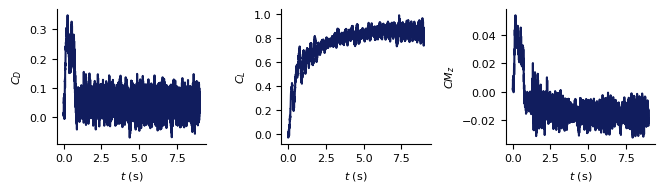

In [2]:
import pandas as pd
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

num_files  = 16     # number of force-coefs files
Alpha0 = 8

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Folder = './inputs/experiments/Steady/AoA' + str(Alpha0) + '/'
nt         = 9000 # length of data
filterFreq = 0.5     # cut-off frequency for filter
dAlpha     = 0     # changes in AoA
RefFreq    = 0     # frequency of the motion

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Import data:
data_raw = {}
for i in range(num_files):
    # import initial data
    fileName = 'Initial_Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[2,4,7], nrows=nt).to_numpy() # transform data to numpy array
    idata = np.mean(idata,axis=0)

    # Import the force data:
    fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    data = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[0,2,4,7], names= ["id","fx","fy","mz"]) 
    
    # group data with the same time-stamps
    time = np.arange(0,nt,1)/1000     # create time-vector: ms -> s
    data_raw[i] = data[["fx","fy","mz"]].copy().to_numpy() # transform data to numpy array

    # Calculate average of the solution:
    if i==0:
        Data = np.zeros((nt,3))
    else:
        Data = Data + data_raw[i][0:nt,:] - idata
# calculate the mean force between experiments
Forces_ = Data/num_files # "fx","fy","mz"

# Fix force coefficient values based of the AoA:
AoA  = Alpha0*np.pi/180 # angle of attack, alpha = alpha(t)

Forces = np.zeros((nt,3)) 
for t in range(nt):
    c, s = np.cos(AoA), np.sin(AoA)
    R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
    Forces[t,:] = R.dot(Forces_[t,:])
Forces[:,2]  = Forces_[:,2] # no need to transform mz

# now they are drag, lift, moment
Forces_[:,:] = Forces[:,:] # fix AoA in original data, Forces_, too.

# Calculate force coefficients: cd, cl, cm
forceCoefs_ = Forces_/(dynP*Span)
forceCoefs_[:,2] = forceCoefs_[:,2]/Chord

# plot cd, cl, cm
names  = ['$C_D$', '$C_L$', '$CM_z$']
limits = [-0.2, 0.5, 0.0, 1.1, -0.1, 0.05]

axs = plt.figure(figsize=(17*cm2in, 5*cm2in)).subplots(1,3)
plt.rcParams['font.size'] = '8'

i = 0
j = 0
for ax in axs.flat:
    ax.plot(time, forceCoefs_[:,i], '-', color='#111D5E' )
    ax.set(ylabel=names[i])
    #ax.set_ylim(limits[j], limits[j+1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_xlim([0, 6])
    #ax.legend(loc='best')
    ax.set(xlabel='$t$ (s)')
    i=i+1   
    j=j+2
plt.tight_layout()

# Calculate lift and drag coefficients:
CD_Mean = np.mean(forceCoefs_[-1000:-1,0])
CL_Mean = np.mean(forceCoefs_[-1000:-1,1])
CM_Mean = np.mean(forceCoefs_[-1000:-1,2])

#plt.show()
plt.savefig('./Outputs/ForceCoefess_Steady.png', bbox_inches='tight', dpi=450)

print("CD:" + f'{CD_Mean:0.3f}')
print("CL:" + f'{CL_Mean:0.3f}')
print("CM:" + f'{CM_Mean:0.3f}')

### Force coefficients vs AoA
Notice that:
 - A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

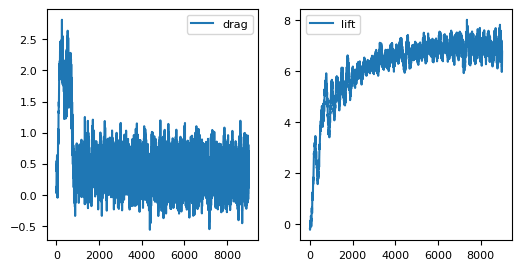

In [3]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
labels = ['drag','lift']
i = 0
for ax in axs.flat:
    ax.plot(Forces_[0:,i],label=labels[i])
    ax.legend()
    i = i+1

In [4]:
# calculate the std of the loads, prepare for the uncertainty calculation
Forces_.shape
stds_force = np.std(Forces_[5000:,:], axis=0)
stds_force

array([0.29949305, 0.29698534, 0.008735  ])

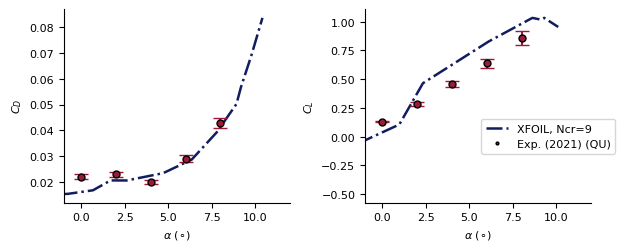

In [5]:
# Import experiments data:
data = pd.read_csv('./inputs/experiments/Steady/ForceCoeffs_vs_AoA.txt', skiprows=0, sep=',').to_numpy()

Chord     = 0.2              # chord length, m
dChord    = 0.001
len_span  = 0.95
dlen_span = 0.02
Span   = Chord*len_span        # airfoil surface area
dSpan  = dChord*dlen_span
rho  = 998               # kg/m^3
drho = 10
u    = 0.3               # m/s
du   = 0.01

# Calculate loads using coefficient (with uncertainty)
# uncertainty: u(F) = sqrt(u_sys^2 + u_rand^2)
# nano25 ip65/68: resolution: 1/24, range:250N
# uncertainty due to the resolution: 1/48N (half of resolution);
# assume the systematic uncertainty is 0.1%: 0.25N
# and the standard deviation
drag   = data[:,1]*(0.5*rho*u**2*Span)
d_drag = np.sqrt((1/48)**2 + (0.25)**2 + (stds_force[0])**2)

lift   = data[:,2]*(0.5*rho*u**2*Span)
d_lift = np.sqrt((1/48)**2 + (0.25)**2 + (stds_force[1])**2)

cd   = drag / (0.5*rho*u**2*Span)
# d_cd = (d_drag/drag) + 2*(drho/rho) + (du/u) + 2*(dSpan/Span)
d_cd   = np.sqrt((1 / (0.5 * rho * u**2 * Span) * d_drag) ** 2 + 
                 (drag / ( 0.5 * rho**2 * u**2 * Span) * drho) ** 2 + 
                 (2*drag / (0.5 * rho * u**3 * Span) * du) ** 2 + 
                 (drag / ( 0.5 * rho * u**2 * Span**2) * dSpan) ** 2)

cl   = lift / (0.5*rho*u**2*Span)
# d_cl = (d_lift/lift) + 2*(drho/rho) + (du/u) + 2*(dSpan/Span)
d_cl   = np.sqrt((1 / (0.5 * rho * u**2 * Span) * d_lift) ** 2 + 
                 (lift / ( 0.5 * rho**2 * u**2 * Span) * drho) ** 2 + 
                 (2*lift / (0.5 * rho * u**3 * Span) * du) ** 2 + 
                 (lift / ( 0.5 * rho * u**2 * Span**2) * dSpan) ** 2)

load   = {}
d_load = {}
load[0] = cd
load[1] = cl
d_load[0] = d_cd
d_load[1] = d_cl

# Import reference data:
Folder = './inputs/reference/AirfoilDataBase_'
infile = ['CD','CL','CM'] # name of the ref-file we will open
limits = [0, 0.1, -0.1, 1.2, -0.06, 0.06]

axs    = plt.figure(figsize=(16*cm2in, 6.5*cm2in)).subplots(1,2)
names  = ['$C_D$', '$C_L$', '$CM_z$']
colors = ['darkorange','teal']

i = 0
j = 0
for ax in axs.flat:
    ax.xaxis.get_label().set_fontsize(8)
    ax.yaxis.get_label().set_fontsize(8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(ylabel=names[i], fontsize = 8)
    ax.set_xlabel(r'$\alpha$ $(\circ)$', fontsize = 8)
    ax.set_xlim([-1, 12])
    # ax.set_ylim(limits[j], limits[j+1])

    # Plot reference data:
    refFile = pd.read_csv(Folder+infile[i]+'_vs_AoA.csv', skiprows=1, sep=',').to_numpy()
    ax.plot(refFile[:,0], refFile[:,1], '-.', color='#111D5E', linewidth=1.8,label='XFOIL, Ncr=9' )

    # Plot experimental data data:
    ax.plot(data[:,0], data[:,i+1],'o', markersize=2, markerfacecolor='#9d1939', linewidth=1.8, markeredgecolor='#000000', label='Exp. (2021) (QU)' )
    ax.errorbar(data[:,0], load[i], yerr=d_load[i]*load[i], fmt='o', ecolor='#9d1939', markersize=5,
                markerfacecolor='#9d1939', markeredgecolor='#000000', capsize=5)

    i=i+1
    j=j+2

ax.legend(ncol=1 , loc='upper center', bbox_to_anchor=(0.81, 0.46))

plt.tight_layout()

plt.savefig('./outputs/ForceCoefess_vs_AoA.png', bbox_inches='tight', dpi=450)

**Plot force coefficients for dynamic cases**

Use the following parametes:
- Case 'A':
    - pitching
    - num_files: 16
    - RefFreq: 0.19
    - dAlpha:  4.5 
- Case 'B':
    - pitching
    - num_files: 16
    - RefFreq: 0.38
    - dAlpha:  4.5 
- Case 'C':
    - pitching
    - num_files: 10
    - RefFreq: 0.19
    - dAlpha:  6.0
- Case 'D':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0  
- Case 'E':
    - plunging
    - num_files: 11
    - RefFreq: 0.38
    - dAlpha:  0 
- Case 'F':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0 
    

In [6]:
# * * * * * * * * * * * * * *
Case       = ['A','B','C','D','E','F']
num_files  = 10    # number of runs for each case; they should have the same runs for post-process
RefFreq    = np.array([0.19, 0.38, 0.19, 0.19, 0.38, 0.19])  # reference frequency, for normalization
dAlpha     = 4.5   # change in AoA: p-to-p, deg
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
nt     = 190   # length of data
Period       = 37 #s, time-interval of analysis
len_period   = int((1/0.19)*1000) # length of one period; samples number
nMotionStart = 17420 # motion starts at this index/instant
nDataPoints  = int(nMotionStart + len_period*3) # total number of data points; three periods can be used
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
# Define AoA:
# Create real-motion profile:
MotionTime = np.linspace(0,Period,nDataPoints)
Alpha0 = 8.0   # mean AoA, deg
Omega  = 2*np.pi*RefFreq
AoA    = np.zeros((nDataPoints,6))
movTime = MotionTime[nMotionStart:nDataPoints] - MotionTime[nMotionStart]
for i in range(6):
    AoA[0:nMotionStart,i] = Alpha0*np.pi/180    # AoA(t<t0) = Alpha0, before pitching or plunging
    AoA[nMotionStart:nDataPoints,i]  = ( Alpha0 + dAlpha*np.sin( Omega[i]*(movTime) ) )*np.pi/180
# * * * * * * * * * * * * * *

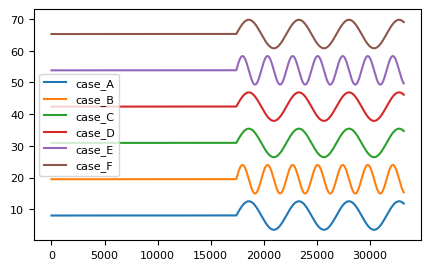

In [7]:
fig,ax = plt.subplots(figsize=(5,3))
for i in range(6):
    ax.plot((AoA[:,i]+0.2*i)*180/np.pi, label='case_'+Case[i]) # add +0.2*i ot distinguish them
ax.legend()

In [8]:
data_global = np.zeros((nDataPoints,3))
data_raw    = {} # initialize a dictionary, with keys and values
forceCoefs_ = {}
# * * * * * * * * * * * * * *
# import data
for k in Case: # loop to read all the six cases
    Folder = './inputs/experiments/Case' + k + '/' # where files are stored
    print(Folder)
    for i in range(num_files): # loop to read all the six cases
        # Import the initial data
        fileName = 'Initial_Force_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, sep=',', usecols=[2,4,7], nrows=5000).to_numpy() # [2,4,7] = "fx","fy","mz"
        idata    = np.mean(idata,axis=0) # take only the average forward

        # Rotate the initial data to the global reference frame: 
        # ALL pitching and plunging cases need do this
        c, s = np.cos(AoA[0,0]), np.sin(AoA[0,0])
        R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
        idata = R.dot(idata)

        # Import the force data:
        fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[0,2,4,7], names= ["id","fx","fy","mz"])
        data = data_raw[k,i][["fx","fy","mz"]].copy().to_numpy() # transform data to numpy array

        # Fix for correct AoA:
        for idx in range(nDataPoints):
            # find index, idx, of the time that "time" corresponds to in the airfoil's motion
            
            # for pitching cases: 'A', 'B', 'C', we need to transform the initial data to the global reference frame:
            if k == 'A':
                c, s = np.cos(AoA[idx,0]), np.sin(AoA[idx,0])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[idx,:] = R.dot(data[idx,:]) - idata
            elif k == 'B':
                c, s = np.cos(AoA[idx,1]), np.sin(AoA[idx,1])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[idx,:] = R.dot(data[idx,:]) - idata
            elif k == 'C':
                c, s = np.cos(AoA[idx,2]), np.sin(AoA[idx,2])
                R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
                data_global[idx,:] = R.dot(data[idx,:]) - idata
            # for plunging cases: 'D', 'E', 'F', no need to transform
            else:
                data_global[idx,:] = data[idx,:] - idata

        # Calculate average of the solution:
        if i==0:
            Data = np.zeros((nDataPoints,3))
        else:
            Data = Data + data_global[:,:]    

    Forces_ = Data/num_files # Calculate the mean:
    Forces_ = Forces_[nMotionStart:nDataPoints] # only save the data with pitching motion
    # * * * * * * * * * * * * * *

    # * * * * * * * * * * * * * *
    # calculate force coefficient
    forceCoefs_[k] = Forces_/(dynP*Span)
    forceCoefs_[k][:,2] = forceCoefs_[k][:,2]/Chord
# * * * * * * * * * * * * * *

# rename forceCoefs_ to CN
CN = forceCoefs_

print("\n==> This code runs OK")

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/

==> This code runs OK


**check the periodic data**

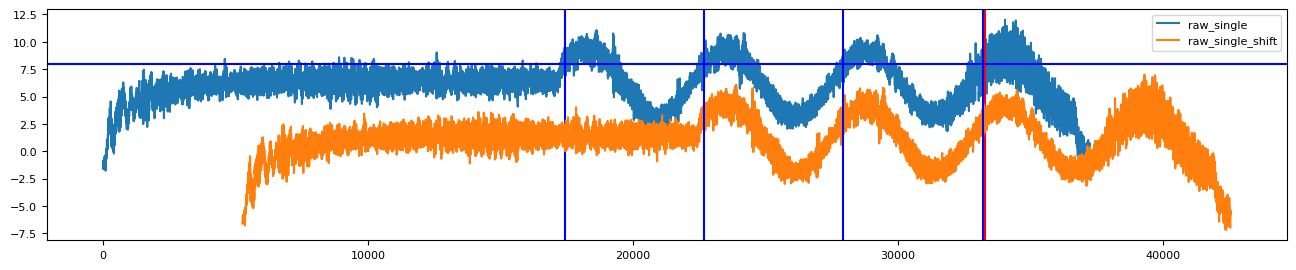

In [9]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(data_raw['A',6]['fy'], label='raw_single')
ax.axvline(x=nDataPoints+100, color='r')
ax.axvline(x=nMotionStart, color='b')
# define the length of one period
ax.plot(np.linspace(0+len_period,37300+len_period,37300), data_raw['A',6]['fy']-5, label='raw_single_shift')
ax.axvline(x=nMotionStart+len_period*1, color='b')
ax.axvline(x=nMotionStart+len_period*2, color='b')
ax.axvline(x=nMotionStart+len_period*3, color='b')
ax.axhline(y=8, color='b')
ax.legend()

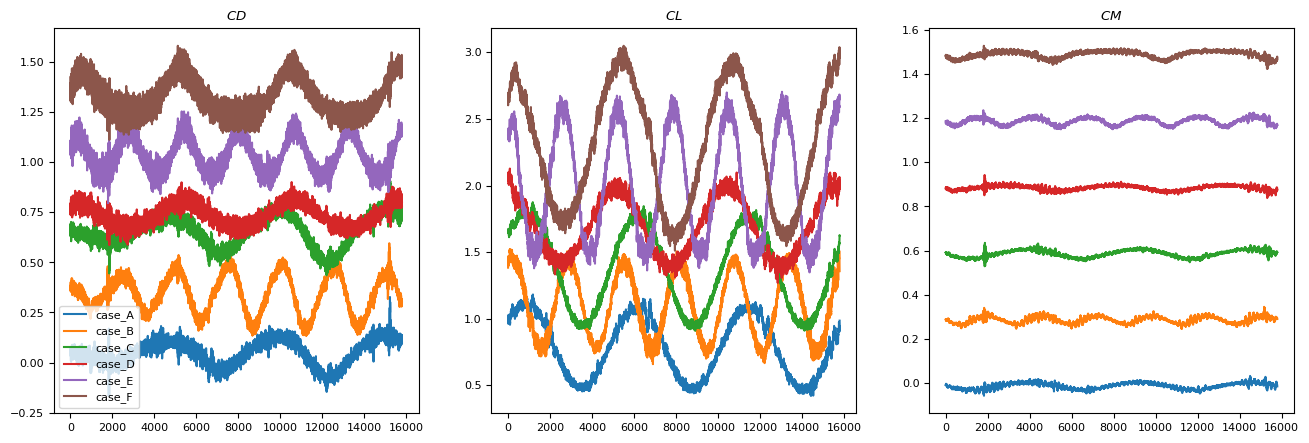

In [10]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for j in [0,1,2]:
    i=0
    for k in Case:
        ax[j].plot(CN[k][:,j]+0.3*i,label='case_'+k) # plus 0.3*i to distinguish them
        i = i+1
    if j == 0:
        ax[j].set_title('$CD$')
    if j == 1:
        ax[j].set_title('$CL$')
    if j == 2:
        ax[j].set_title('$CM$')
ax[0].legend()
# plt.tight_layout()

**Plot all forces of dynamic cases together**

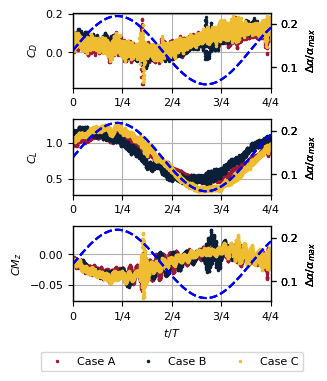

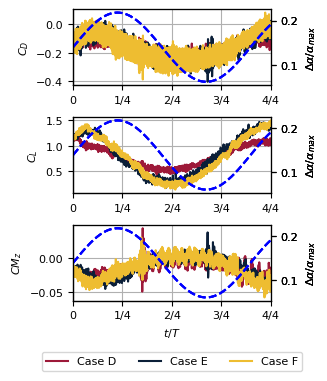

In [11]:
# convert all the six cases into one period, for camprasion
# for case a


Cases   = ['A', 'B', 'C']
ncases  = np.size(Cases) # number of cases to post-process
RefFreq = [0.19, 0.38, 0.19]

# Angle-of-attack, AoA = AoA(t)
time = np.linspace(0, 1, 100)
AoA_motion = AoA[nMotionStart:nMotionStart+len_period]

# * * * * * * * * * * * * * *
# plot all pitching cases
axs = plt.figure(figsize=(8.6*cm2in, 10*cm2in)).subplots(3,1)
limits = [-0.05, 0.15, 0.0, 1.5, -0.05, 0.05]

names  = ['$C_D$', '$C_L$', '$CM_z$'] # names of variables
for n in ['A','B','C']:
    i = 0   
    j = 0
    p = 0
    Icon, Color = myCases(n)

    for ax in axs.flat:
        if n == 'A':
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'B': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,int(len_period/2)),CN[n][0:int(len_period/2),i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'C': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        else:
            print('Error')
        
        ax.grid()
        ax.xaxis.get_label().set_fontsize(8)
        ax.yaxis.get_label().set_fontsize(8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(ylabel=names[i], fontsize = 8)

        # Set x-axis to multiples of t/T/4
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(['0','1/4','2/4','3/4', '4/4'])

        # Update for next iteration:
        i=i+1
        j=j+2
        
        # Create second axis for AoA:
        ax2=ax.twinx()
        ax2.plot(np.linspace(0,1,len_period), AoA_motion[0:len_period,0], 'b--')
        ax2.set(ylabel=r'$\Delta \alpha/\alpha_{max}$')
        
        ax.margins(x=0)
        
    p = p+1
    
ax.set_xlabel(r'$t/T$', fontsize = 8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6),fancybox=True, ncol=3)

plt.tight_layout()
plt.savefig('./Outputs/ForceCoefess_PitchingMotion.png', bbox_inches='tight', dpi=350)
# * * * * * * * * * * * * * *

# * * * * * * * * * * * * * *
# plot all plunging cases

Cases   = ['D', 'E', 'F']
ncases  = np.size(Cases) # number of cases to post-process
axs = plt.figure(figsize=(8.6*cm2in, 10*cm2in)).subplots(3,1)

for n in ['D','E','F']:
    i = 0   
    j = 0
    p = 0
    Icon, Color = myCases(n)

    for ax in axs.flat:
        if n == 'D':
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'E': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,int(len_period/2)),CN[n][0:int(len_period/2),i], Icon, markersize=3, color=Color,  label='Case ' + n )
        elif n == 'F': # case b has two periods while a or c has one period
            ax.plot(np.linspace(0,1,len_period), CN[n][0:len_period,i], Icon, markersize=3, color=Color,  label='Case ' + n )
        else:
            print('Error')
        
        ax.grid()
        ax.xaxis.get_label().set_fontsize(8)
        ax.yaxis.get_label().set_fontsize(8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(ylabel=names[i], fontsize = 8)

        #  Set x-axis to multiples of t/T/4
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(['0','1/4','2/4','3/4', '4/4'])

        # Update for next iteration:
        i=i+1
        j=j+2
        
        # Create second axis for AoA:
        ax2=ax.twinx()
        ax2.plot(np.linspace(0,1,len_period), AoA_motion[0:len_period,0], 'b--')
        ax2.set(ylabel=r'$\Delta \alpha/\alpha_{max}$')
        
        ax.margins(x=0)
        
    p = p+1
    
ax.set_xlabel(r'$t/T$', fontsize = 8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6),fancybox=True, ncol=3)

plt.tight_layout()
plt.savefig('./Outputs/ForceCoefess_PlungingMotion.png', bbox_inches='tight', dpi=350)
# * * * * * * * * * * * * * *


**Plot pressure contours for steady case**


==> This code runs OK


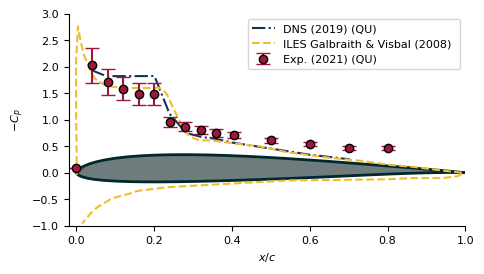

In [331]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

markers = ['.', ':s', ':o']
colours = ['#061D38', '#061D38', '#061D38']
labels =  [r'DNS (2019) (QU)', 'G&V (2008)','Exp. (QU)'] 

# Import reference pressure data
cp_DNS = pd.read_csv('./inputs/reference/cp_DNS.csv',            skiprows=1, sep=',', usecols = [0,1]).to_numpy()
cp_GV8 = pd.read_csv('./inputs/reference/cp_Galbraith_AoA8.csv', skiprows=1, sep=',', usecols = [0,1]).to_numpy()

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Folder = './inputs/experiments/Steady/AoA8/'
num_files       = 10 # number of files
num_extra_files = 3 # number of extra pressure ports
skiplines  = 15000  # skip transient stage
nt         = 15000  # desired length of data 
filterFreq = 1      # cut-off frequency for filter

# this is the order of the measured pressure ports
Columns10 = [0,2,3,4,5,6,7,8,9,10,11] # np.linspace(0,nports+1,nports,dtype=int)
Names10   = ['id','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
nports1   = 10

Columns5  = [0,2,3,4,5,6,7]
Names5    = ['id','p1','p15','p14','p13','p12','p11']
nports2   = 6

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# First 10 pressure ports
data_raw = {}
for i in range(num_files):
    fileName = 'Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10).to_numpy()
    idata    = np.mean(idata[:,1:],axis=0) # take only the average forward
    
    fileName    = 'Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    data_raw[i] = pd.read_csv(Folder+fileName, skiprows=skiplines, sep=',', usecols=Columns10, names=Names10).to_numpy()
    data        = data_raw[i][:nt,1:]

    # fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]
    # Correct pressure values
    for j in range(1,nports1):
        idata[j]  = idata[j]*fix[j]  - idata[0]*fix[0]
        data[:,j] = data[:,j]*fix[j] - data[:,0]*fix[0]
    idata[0]  = idata[0]*fix[0] 
    data[:,0] = data[:,0]*fix[0]

    # Calculate average of the solution:
    if i == 0:
        Data10 = np.zeros((nt, nports1))
    else:
        Data10 = Data10 + data - idata

# Calculate average:
Data10 = Data10/num_files

# Last 5 pressure ports * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Data5  = np.zeros([nt,nports2])  # original data
data_raw = {}
for i in range(num_extra_files):   
    fileName = 'extra_pressure_ports/Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5).to_numpy()
    idata    = np.mean(idata[:,1:],axis=0) # take only the average forward

    fileName    = 'extra_pressure_ports/Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
    data_raw[i] = pd.read_csv(Folder+fileName, skiprows=skiplines, sep=',', usecols=Columns5, names=Names5).to_numpy()
    data        = data_raw[i][:nt,1:]

    # Correct pressure values
    for j in range(1,nports2):
        idata[j]  = idata[j]*fix[j]  - idata[0]*fix[0] 
        data[:,j] = data[:,j]*fix[j] - data[:,0]*fix[0]

    # Calculate average of the solution:
    if i==0:
        Data5 = np.zeros((nt,nports2))
    else:
        Data5 = Data5 + data - idata

# Calculate average:
Data5 = Data5/num_extra_files

#   * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
# Create pressure value:
Data = np.zeros((nt,nports1+nports2-1))
Data_filt = np.zeros((nt,nports1+nports2-1))
Data[:,0:nports1]  = Data10
Data[:,nports1:] = Data5[:,1:]
Data = Data - 35
from scipy.signal import filtfilt
from scipy.signal import bessel
b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
for i in range(15):
    Data_filt[:,i] = filtfilt(b, a, Data[:,i])
p = np.mean(Data_filt,axis=0) #- 35 # pressure is equal to the average over time minus absolute value; 
                              # -35pa is calibration due to unevenness of the traverse
    
# Calculate loads using coefficient (with uncertainty)
# uncertainty: u(P) = sqrt(u_sys^2 + u_rand^2)
# px409: 0.25pa
# uncertainty due to the resolution: 0.25/2=0.125pa (half of resolution);
# the systematic uncertainty is 0.08%: 2500*0.08%=2pa
# and the standard deviation

stds_p = np.std(Data_filt[5000:,:],axis=0)
d_p    = np.sqrt((0.125)**2 + (2)**2 + (stds_p)**2)
Cp     = p / (0.5*rho*u**2)
d_Cp   = np.sqrt((1 / (0.5 * rho * u**2) * d_p) ** 2 + 
                 (p / ( 0.5 * rho**2 * u**2) * drho) ** 2 + 
                 (2*p / (0.5 * rho * u**3) * du) ** 2)
#   * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

# Plot results
fig, ax = plt.subplots(figsize=(13*cm2in, 7*cm2in))

ax.set_ylabel(r'$-C_p$')
ax.set_xlabel('$x/c$')
ax.set_xlim([-0.02, 1])
ax.set_ylim([-1.0,3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Draw airfoil:
ax.fill(xs,ys, edgecolor='#00282b', facecolor='#6f7c7d',linewidth=2) 

# Add reference data:
plt.plot(cp_DNS[:,0],-cp_DNS[:,1],'-.', color='#11335d',label = 'DNS (2019) (QU)')
plt.plot(cp_GV8[:,0],cp_GV8[:,1],'--', color='#eebd31',label = 'ILES Galbraith & Visbal (2008) ')

# Plot experiment data:
# ax.plot(xports,-p/dynP,'o', markerfacecolor='#9d1939', markeredgecolor='#000000',label = 'Exp. (2021) (QU)', linewidth=2.5)
ax.errorbar(xports,-Cp,yerr=abs(d_Cp*Cp), fmt='o', ecolor='#9d1939', 
            markerfacecolor='#9d1939', markeredgecolor='#000000', capsize=5,
            label = 'Exp. (2021) (QU)', linewidth=1.5)

# Add legendes:
ax.legend(loc='best')

plt.savefig('./Outputs/PressureCoeffs_Steady.png', bbox_inches='tight', dpi=300)

print("\n==> This code runs OK")

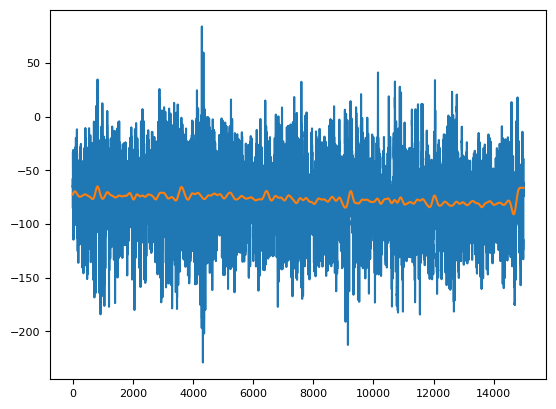

In [333]:
plt.plot(Data[:,2])
plt.plot(Data_filt[:,2])

**Post-process pressure contours for dynamic cases**

Use the following parametes:
- Case 'A':
    - RefFreq: 0.19
- Case 'B':
    - RefFreq: 0.38
- Case 'C':
    - RefFreq: 0.19
- Case 'D':
    - RefFreq: 0.19
- Case 'E':
    - RefFreq: 0.38
- Case 'F':
    - RefFreq: 0.19

In [483]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# First 10 pressure ports 
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Case      = ['A','B','C','D','E','F']
Cp_dyna   = {}
Cp_dyna         = {}

for k in Case:
    # First 10 pressure ports 
    Folder = './inputs/experiments/Case' + k + '/'
    print(Folder)
    Data_10 = np.zeros((nDataPoints,nports1))
    for i in range(num_files):
        fileName = 'Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10).to_numpy()
        idata    = np.mean(idata[:,1:],axis=0) # take only the average forward

        fileName = 'Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw_10 = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10, names=Names10).to_numpy()
        data     = data_raw_10[:,1:]

        # fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5]
        # Correct pressure values
        for j in range(1,nports1):
            idata[j]  = idata[j]*fix[j]  - idata[0]*fix[0] 
            data[:,j] = data[:,j]*fix[j] - data[:,0]*fix[0]
        idata[0] = idata[0]*fix[0]
        data[:,0] = data[:,0]*fix[0]

        # Calculate average of the solution:
        if i==0:
            Data_10 = np.zeros((nDataPoints,nports1))
        else:
            Data_10 = Data_10 + data[0:nDataPoints,:] - idata

    # Calculate average:
    Data_10 = Data_10/num_files
    
    # Last 5 pressure ports
    Data_5 = np.zeros((nDataPoints,nports2))
    for i in range(num_files):   
        fileName = 'extra_pressure_ports/Initial_Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        idata    = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5).to_numpy()
        idata    = np.mean(idata[:,1:],axis=0) # take only the average forward

        fileName   = 'extra_pressure_ports/Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        data_raw_5 = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5, names=Names5).to_numpy()
        data       = data_raw_5[:,1:]

        # Correct pressure values
        for j in range(1,nports2):
            idata[j]  = idata[j]*fix[j]  - idata[0]*fix[0] 
            data[:,j] = data[:,j]*fix[j] - data[:,0]*fix[0]

        # Calculate average of the solution:
        if i==0:
            Data_5 = np.zeros((nDataPoints,nports2))
        else:
            Data_5 = Data_5 + data[0:nDataPoints,:] - idata

    # Calculate average:
    Data_5 = Data_5/num_extra_files
    
    # Create pressure value:
    Data = np.zeros((nDataPoints,nports1+nports2-1))
    Data[:,0:nports1]  = Data_10
    Data[:,nports1:]   = Data_5[:,1:]

    # calibrate by 35pa
    Data = Data - 35 
    
    # filter data
    for i in range(15):
        Data[:,i] = filtfilt(b, a, Data[:,i]) / dynP
    
    # calculate Cp
    Cp_dyna[k] = Data[nMotionStart:nDataPoints]
    
print('done')

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/
done


In [ ]:
plt.plot(CN['A'][:,0],label='cd')
plt.plot(CN['A'][:,1],label='cl')
plt.plot(CN['A'][:,2],label='cm')
plt.legend()

**combine cp and cn together and save as pandas dataframe**

In [511]:
import pandas as pd
columnName = ['cp1', 'cp2', 'cp3', 'cp4', 'cp5', 'cp6', 'cp7', 'cp8', 
              'cp9', 'cp10', 'cp11', 'cp12', 'cp13', 'cp14', 'cp15', 
              'cd', 'cl', 'cm']
df_sd7003_temp = {}
for k in Case:
    sd7003_temp = np.concatenate((Cp_dyna[k], CN[k]), axis=1)
    df_sd7003_temp[k] = pd.DataFrame(sd7003_temp, index=['case_'+k]*sd7003_temp.shape[0], columns=columnName)

# combine DataFrames into one larger DataFrame
df_sd7003 = pd.concat(df_sd7003_temp.values())

In [515]:
df_sd7003.tail()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,cp11,cp12,cp13,cp14,cp15,cd,cl,cm
case_F,4.399998,-4.566203,-2.996317,-2.467514,-2.252857,-2.448594,-2.115342,-1.593805,-1.624412,-1.399064,-3.122402,-2.669847,-2.132148,-1.693723,-1.66738,-0.072713,1.529884,-0.019520
case_F,4.399998,-4.566203,-2.996317,-2.467514,-2.252857,-2.448594,-2.115342,-1.593805,-1.624412,-1.399064,-3.122402,-2.669847,-2.132148,-1.693723,-1.66738,-0.048722,1.487178,-0.020914
case_F,4.399998,-4.566203,-2.996317,-2.467514,-2.252857,-2.448594,-2.115342,-1.593805,-1.624412,-1.399064,-3.122402,-2.669847,-2.132148,-1.693723,-1.66738,-0.006863,1.486599,-0.025425
case_F,4.399998,-4.566203,-2.996317,-2.467514,-2.252857,-2.448594,-2.115342,-1.593805,-1.624412,-1.399064,-3.122402,-2.669847,-2.132148,-1.693723,-1.66738,0.013027,1.498760,-0.028678
case_F,4.399998,-4.566203,-2.996317,-2.467514,-2.252857,-2.448594,-2.115342,-1.593805,-1.624412,-1.399064,-3.122402,-2.669847,-2.132148,-1.693723,-1.66738,0.029653,1.508426,-0.031073


**check and plot the data**

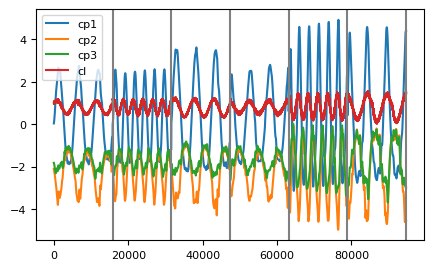

In [544]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(df_sd7003['cp1'].to_numpy(),label='cp1')
ax.plot(df_sd7003['cp2'].to_numpy(),label='cp2')
ax.plot(df_sd7003['cp3'].to_numpy(),label='cp3')
ax.plot(df_sd7003['cl'].to_numpy(),label='cl')
for i in range(6):
    ax.axvline(x=len_period*3*(i+1), color='gray')
plt.legend(loc=2)
fig.savefig('sd7003_check_plot.png', bbox_inches='tight',dpi=350)

**save the dataframe to .csv for future use**

In [528]:
df_sd7003.to_csv('../df_sd7003.csv', index=True)